In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import os
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [2]:
#Read in Data
Nat_Gas = os.path.join(os.path.expanduser("~"), "Desktop", "Natural_Gas_daily.csv")
df = pd.read_csv(Nat_Gas)
df = df.set_index('Date')
df.head()


,Price
Date,
1/7/97,3.82
1/8/97,3.80
1/9/97,3.61
1/10/97,3.92
1/13/97,4.00


In [3]:
df.index = pd.to_datetime(df.index)
df.dtypes

Price    float64
dtype: object

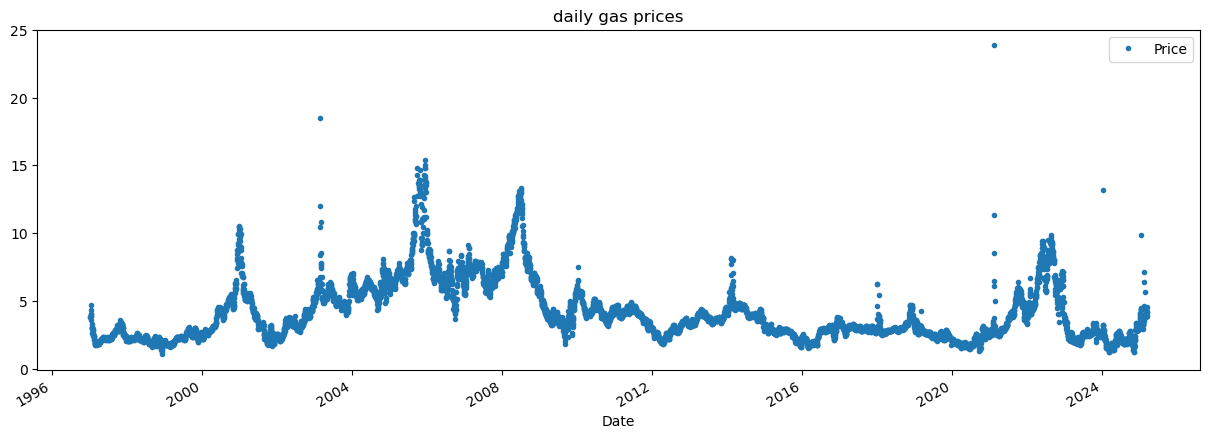

In [4]:
df.plot(style='.',
        figsize=(15, 5),
        title='daily gas prices')
plt.show()


<Axes: ylabel='Frequency'>

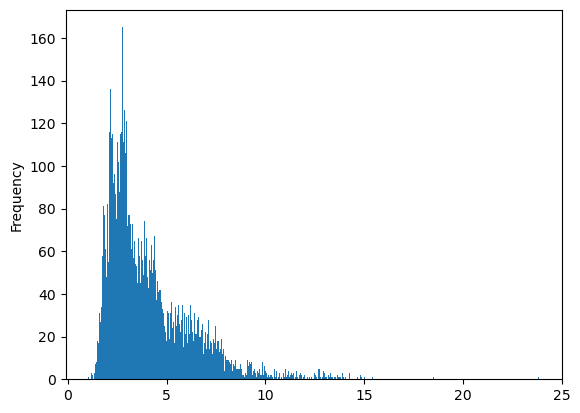

In [5]:
df['Price'].plot(kind='hist', bins=500)

In [6]:
df = df.query('Price < 14.49').copy()

<Axes: ylabel='Frequency'>

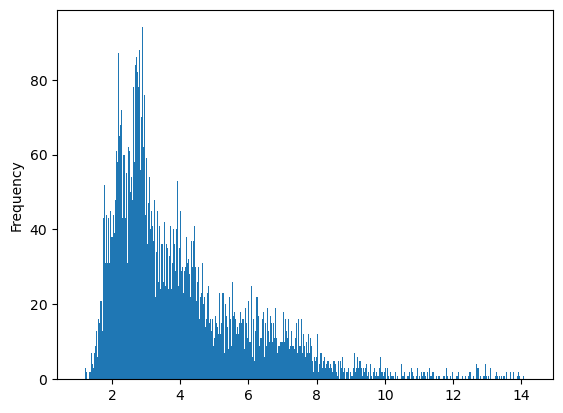

In [7]:
df['Price'].plot(kind='hist', bins=500)

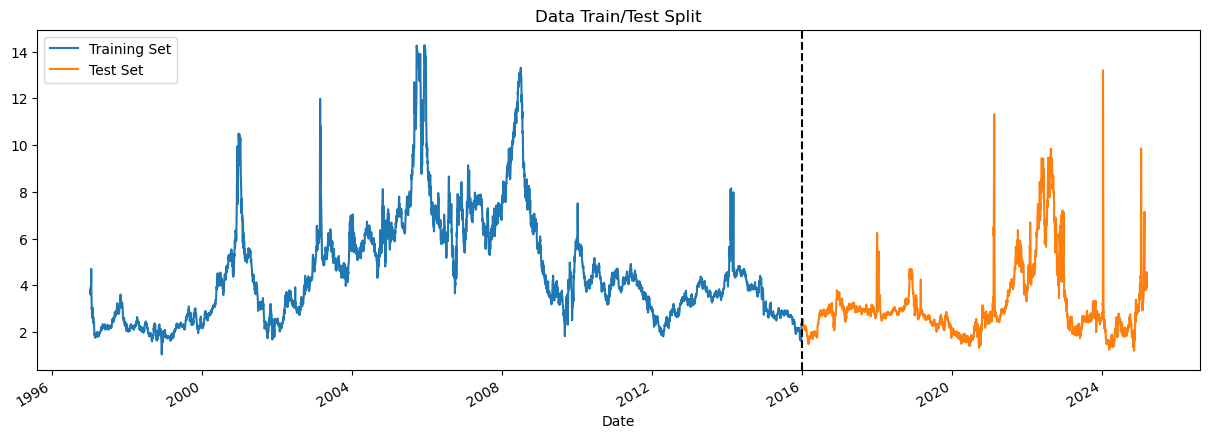

In [8]:
#Train/Test Split
train = df.loc[df.index < '01-01-2016']
test = df.loc[df.index >= '01-01-2016']
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2016', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [9]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)
df.head()

,Price,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,
1997-01-07,3.82,1,1,1,1997,7,7,2
1997-01-08,3.80,2,1,1,1997,8,8,2
1997-01-09,3.61,3,1,1,1997,9,9,2
1997-01-10,3.92,4,1,1,1997,10,10,2
1997-01-13,4.00,0,1,1,1997,13,13,3


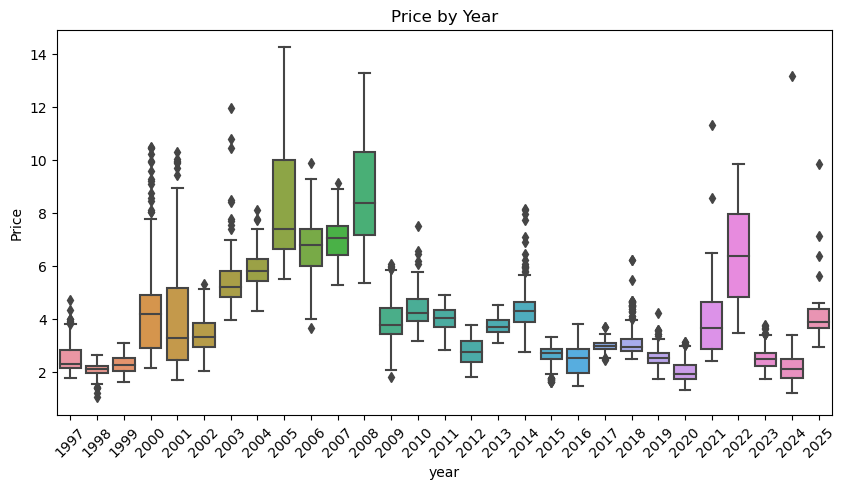

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=df, x='year', y='Price')
ax.set_title('Price by Year')
plt.xticks(rotation=45)
plt.show()

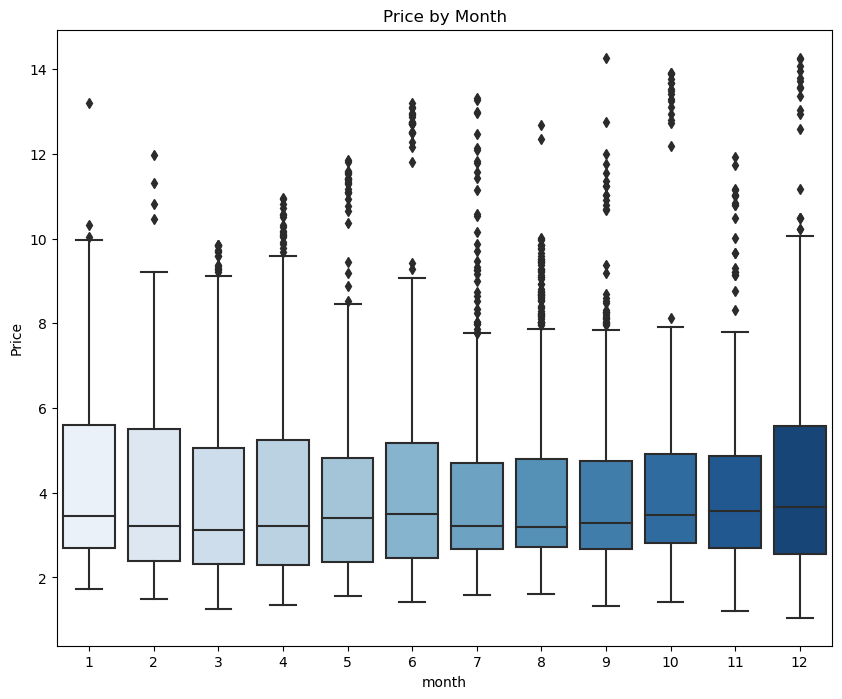

In [11]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='Price', palette='Blues')
ax.set_title('Price by Month')
plt.show()


In [12]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'Price'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [16]:
X_test.head()

,dayofyear,dayofweek,quarter,month,year
Date,,,,,
2016-01-01,1,4,1,1,2016
2016-01-04,4,0,1,1,2016
2016-01-05,5,1,1,1,2016
2016-01-06,6,2,1,1,2016
2016-01-07,7,3,1,1,2016


In [17]:
y_test.head()

Date
2016-01-01    2.28
2016-01-04    2.39
2016-01-05    2.33
2016-01-06    2.37
2016-01-07    2.35
Name: Price, dtype: float64

In [18]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8]
}

# Initialize XGBoost regressor
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_reg,
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=3,
                           verbose=1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Make predictions on the test set using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE on test set:", rmse)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best score: -4.589471791452416
RMSE on test set: 1.6482732766809856


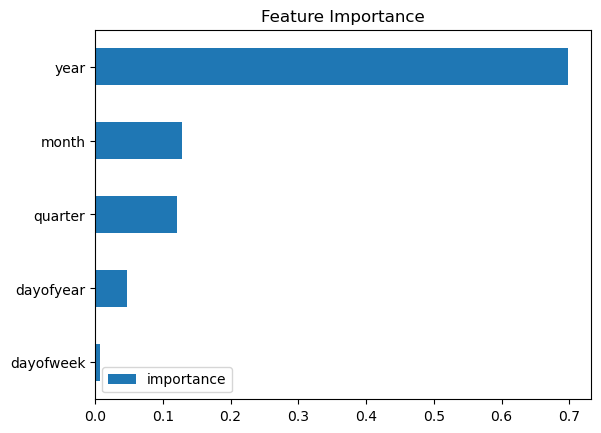

In [19]:
fi = pd.DataFrame(data=best_model.feature_importances_,
             index=best_model.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

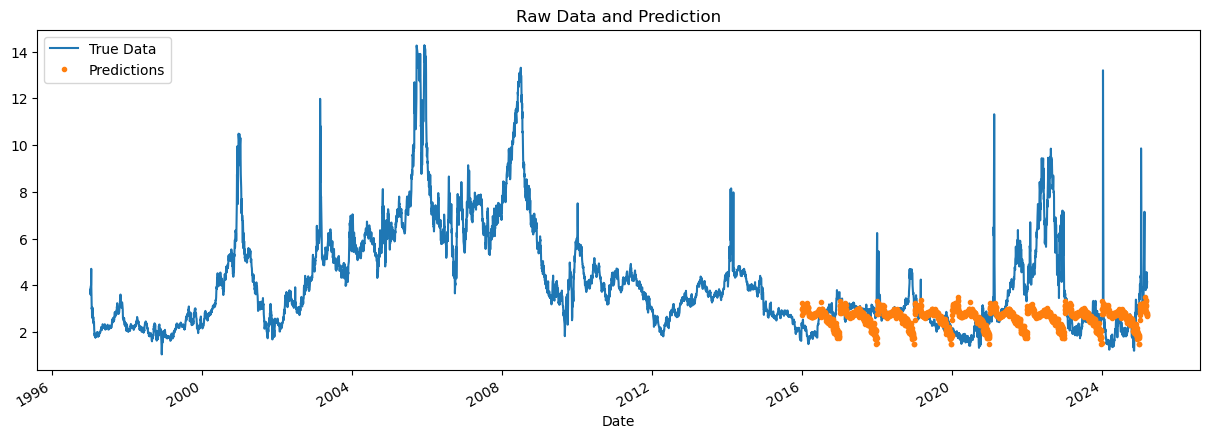

In [20]:
#Forecast on Test set
test['prediction'] = best_model.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['Price']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['True Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [115]:
score = np.sqrt(mean_squared_error(test['Price'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')


RMSE Score on Test set: 1.31
